In [17]:
%matplotlib inline

import xarray as xa
import netCDF4 as nc
import pandas as pd
import numpy as np
import urllib
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

In [18]:
### Plot settings
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'white'
mpl.rcParams['axes.linewidth'] = 0.25
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['font.size'] = 24
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['svg.fonttype'] = 'none'

The following cell loads the dataset from an ERDDAP server.  It can be accessed like a opendap/thredds server for netcdf, but sends the data in a **streaming** format which is hard to figure out how to parse.  So instead, download a temporary file specifying the parameters in the url. 

Alternatives would be to access streaming version of csv file or other filetype from ERDDAP Server and process via pandas

In [19]:
ALAMOID = "http://ferret.pmel.noaa.gov/alamo/erddap/tabledap/arctic_heat_alamo_profiles_9119"
cmap = cmocean.cm.thermal
temp_filename = "data/tmp.nc"

start_date="2017-09-12"
end_date  ="2017-12-31" 
urllib.urlretrieve(ALAMOID+".ncCFMA?profileid%2CFLOAT_SERIAL_NO%2CCYCLE_NUMBER%2CREFERENCE_DATE_TIME%2CJULD%2Ctime%2Clatitude%2Clongitude%2CPRES%2CTEMP%2CPSAL&time%3E="+start_date+"T23%3A52%3A00Z",temp_filename)

start_date_dt = datetime.datetime.strptime(start_date,"%Y-%m-%d"),
end_date_dt   = datetime.datetime.strptime(end_date,"%Y-%m-%d")

In [20]:
#datanc = nc.Dataset('data/tmp.nc') #using netcdf library
dataxa = xa.open_dataset('data/tmp.nc')

#print dataxa

In [21]:
def plot_temperature():
    depth_array = np.arange(0,55,0.25)
    temparray = np.ones((dataxa.dims['profile'],len(depth_array)))*np.nan
    ProfileTime = []
    cycle_col = 0

    plt.figure(1, figsize=(18, 3), facecolor='w', edgecolor='w')
    plt.subplot(1,1,1)
    ax1=plt.gca()
    
    for cycle in range(dataxa['profile'].min(),dataxa['profile'].max()+1,1):
        temp_time =  dataxa.time[cycle].data[~np.isnat(dataxa.time[cycle].data)]
        ProfileTime = ProfileTime + [temp_time]
        #remove where pressure may be unknown
        Pressure = dataxa.PRES[cycle].data[~np.isnan(dataxa.PRES[cycle].data)]
        Temperature = dataxa.TEMP[cycle].data[~np.isnan(dataxa.PRES[cycle].data)]

        temparray[cycle_col,:] = np.interp(depth_array,np.flip(Pressure,axis=0),np.flip(Temperature,axis=0),
                                           left=np.nan,right=np.nan)
        cycle_col +=1

        ###plot black dots at sample points
        #plt.scatter(x=temp_time, y=Pressure,s=1,marker='.', edgecolors='none', c='k', zorder=3, alpha=1)
        ###plot colored dots at sample points with colorscheme based on  variable value
        plt.scatter(x=temp_time, y=Pressure,s=30,marker='.', edgecolors='none', c=Temperature, 
          vmin=-2, vmax=7, cmap=cmocean.cm.thermal, zorder=2)

    time_array = np.array([x[0] for x in ProfileTime])
    plt.contourf(time_array,depth_array,temparray.T, 
        extend='both', cmap=cmocean.cm.thermal, 
        levels=np.arange(-2,7,0.25), alpha=0.9,zorder=1)

    plt.contour(time_array,depth_array,temparray.T,np.arange(-2,7,1), colors='#d3d3d3',linewidths=1, alpha=1.0,zorder=3)

    ax1.invert_yaxis()
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    ax1.xaxis.set_major_locator(DayLocator(bymonthday=1))
    ax1.xaxis.set_minor_locator(DayLocator(bymonthday=range(0,31,5)))
    ax1.xaxis.set_major_formatter(ticker.NullFormatter())
    ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
    ax1.xaxis.set_major_formatter(DateFormatter('%b %y'))
    ax1.xaxis.set_tick_params(which='major', pad=25)
    ax1.xaxis.set_tick_params(which='minor', pad=5)
    #ax1.set_xlim([start_date_dt,end_date_dt])
    ax1.set_ylim([50,0])

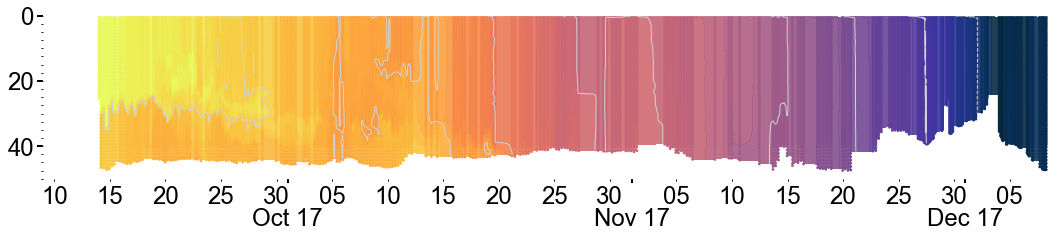

In [22]:
plot_temperature()

In [23]:
def plot_salinity():
    depth_array = np.arange(0,50,0.5)
    temparray = np.ones((dataxa.dims['profile'],len(depth_array)))*np.nan
    ProfileTime = []
    cycle_col = 0

    plt.figure(1, figsize=(18, 3), facecolor='w', edgecolor='w')
    plt.subplot(1,1,1)
    ax1=plt.gca()

    for cycle in range(dataxa['profile'].min(),dataxa['profile'].max()+1,1):
        temp_time =  dataxa.time[cycle].data
        ProfileTime = ProfileTime + [temp_time]
        Pressure = dataxa.PRES[cycle].data
        Salinity = dataxa.PSAL[cycle].data

        temparray[cycle_col,:] = np.interp(depth_array,
                                           np.flip(Pressure,axis=0),
                                           np.flip(Salinity,axis=0),
                                           left=np.nan,right=np.nan)
        cycle_col +=1

        ###plot black dots at sample points
        #plt.scatter(x=temp_time, y=Pressure,s=1,marker='.', edgecolors='none', c='k', zorder=3, alpha=1)
        ###plot colored dots at sample points with colorscheme based on  variable value
        plt.scatter(x=temp_time, y=Pressure,s=30,marker='.', edgecolors='none', c=Salinity, 
          vmin=31, vmax=32.5, cmap=cmocean.cm.haline, zorder=1)

    time_array = np.array([x[0] for x in ProfileTime])
    plt.contourf(time_array,depth_array,temparray.T, 
        extend='both', cmap=cmocean.cm.haline, 
        levels=np.arange(31,32.5,0.05), alpha=0.9)


    ax1.invert_yaxis()
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    ax1.xaxis.set_major_locator(DayLocator(bymonthday=15))
    ax1.xaxis.set_minor_locator(DayLocator(bymonthday=range(0,31,5)))
    ax1.xaxis.set_major_formatter(ticker.NullFormatter())
    ax1.xaxis.set_minor_formatter(DateFormatter('%d'))
    ax1.xaxis.set_major_formatter(DateFormatter('%b %y'))
    ax1.xaxis.set_tick_params(which='major', pad=25)
    #ax1.set_xlim([start_date_dt,end_date_dt])
    ax1.set_ylim([50,0])

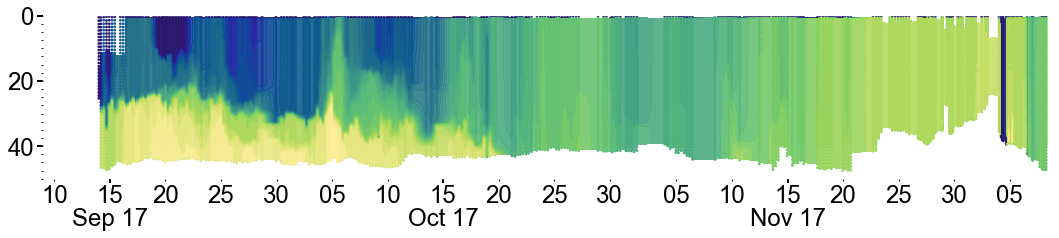

In [24]:
plot_salinity()